# 4 ニューラルネットワークの学習

本章のテーマは、ニューラルネットワークの学習です。ここでいう「学習」とは、訓練データから最適な重みパラメータの値を自動で獲得することを指します。本章では、ニューラルネットワークが学習を行えるようにするために、損失関数という「指標」を導入します。この損失関数を基準として、その値が最も小さくなる重みパラメータを探し出すということが学習の目的です。本章では、できるだけ小さな損失関数の値を探し出すための手法として、勾配法と呼ばれる、関数の傾きを使った手法を説明します。

## 4.1 データから学習する

### 4.1.1 データ駆動

ゼロから「５」を認識するアルゴリズムを"ひねり出す"代わりに、データを有効に活用して解決したいと考えます。

ニューラルネットワークは、画像を"そのまま"学習思案す。特徴量と機械学習によるアプローチの例では人が特徴量を設計しましたが、ニューラルネットワークは、画像に含まれる重要な特徴量までも「機械」が学習するのです。

### 4.1.2 訓練データとテストデータ

機械学習の問題では、**訓練データ**と**テストデータ**の２つのデータに分けて、学習や実験などを行うのが一般的です。その場合、まずは訓練データだけを使って学習を行い、最適なパラメータを探索します。そして　、テストデータを使って、その訓練したモデルの実力を評価するのです。

**汎化能力**とは、まだ見ぬデータ（訓練データに含まれないデータ）に対しての能力であり、この汎化能力を獲得することこそが機械学習の最終的な目標です。

あるデータセットだけに過度に対応した状態を**過学習**（overwriting）と言います。過学習を避けることは、機械学習の重要な課題でもあります。

## 4.2 損失関数

ニューラルネットワークは「ひとつの指標」を手掛かりに最適なパラメータを探索します。なお、ニューラルネットワークの学習で用いられる指標は、**損失関数**（loss function）と呼ばれます。この損失関数は、任意の関数を用いることができますが、一般的には、２乗和誤差や交差エントロピー誤差などが用いられます。

### 4.2.1 ２乗和誤差

$$
E = \frac{1}{2}\sum_{k}(y_k - t_k)^2
\tag{4.1}
$$

ここで、$y_k$はニューラルネットワークの出力、$t_k$は教師データを表し、$k$はデータの次元数を表します。

In [4]:
import numpy as np

def sum_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

# 「２」を正解とする
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [5]:
# 「２」の確率が最も高い場合
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
sum_squared_error(np.array(y), np.array(t))

np.float64(0.09750000000000003)

In [6]:
# 「２」の確率が最も高い場合
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.1, 0.6, 0.0]
sum_squared_error(np.array(y), np.array(t))

np.float64(0.6025)

ひとつ目の例のほうが、出力結果が教師データにより適合していることを２乗和誤差は示しているのです。

### 4.2.2 交差エントロピー誤差

$$
E = -\sum_{k}t_k\log{y_k}
\tag{4.2}
$$

In [7]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

np.logの計算時に、微小な値であるdeltaを足して計算しています。これは、np.log(0)のような計算が発生した場合にもエラーとならないようにするためです。

In [8]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

np.float64(0.510825457099338)

In [9]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.1, 0.6, 0.0]
cross_entropy_error(np.array(y), np.array(t))

np.float64(2.302584092994546)

これらの結果から、これまでの議論と一致していることがわかります。

### 4.2.3 ミニバッチ学習

機械学習の問題は、訓練データを使って学習を行います。訓練データを使って学習するとは、正確に言うと、訓練データに対する損失関数を求め、その値をできるだけ小さくするようなパラメータを探し出す、ということです。そのため、損失関数は、すべての訓練データを対象として求める必要があります。つまり、訓練データが100個あれば、その100個の和を損失関数の指標とするのです。

先ほど説明した損失関数の例は、ひとつのデータの損失関数を考えていました。そこで、訓練データすべての損失関数の和を求めたいとすると、たとえば、交差エントロピーの場合、次の式（4.3）のように書くことができます。

$$
E = -\frac{1}{N}\sum_{n}\sum_{k}t_{nk}\log{y_{nk}}
\tag{4.3}
$$

ここで、データがN個あるとして、$t_{nk}$は$n$番目のデータの$k$番目の値を意味します。（$y_{nk}$はニューラルネットワークの出力、$t_{nk}$は教師データです）。

すべてのデータを対象とした損失関数を計算するのは、現実的ではありません。そこで、データの中から一部を選び出し、その一部のデータを全体の「近似」として利用します。ニューラルネットワークの学習においても、訓練データからある枚数だけを選び出し-これをミニバッチ（小さな塊）という-、そのミニバッチごとに学習を行います。このような学習手法を**ミニバッチ学習**と言います。

In [10]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) =\
load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


それでは、この訓練データの中からランダムに10枚だけ抜き出すには、どうすればよいでしょうか？

In [11]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
print(batch_mask)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]
# print(x_batch)
# print(t_batch)

[ 6029 48984 21934 51674 57800 21298 34476 25625 43352 39779]


np.random.choice()を使えば、指定された数字の中からランダムに好きな数だけ取り出すことができます。

In [12]:
np.random.choice(60000,10)

array([46093, 48030, 41096, 58164, 20249, 40126, 36542, 56488, 18565,
       22419], dtype=int32)

後は、このランダムに選ばれたインデックスを指定して、ミニバッチを取り出すだけです。このミニバッチを使って、損失関数を計算します。

In [13]:
print(np.log(np.array([1.0,2.0,3.0])+3.0))

[1.38629436 1.60943791 1.79175947]


In [14]:
print(np.log(4))

1.3862943611198906


### 4.2.4 なぜ損失関数を設定するのか？

ニューラルネットワークの学習の際に、認識制度を"指標"にしてはいけない。その理由は、認識制度を指標にすると、パラメータの微分がほとんどの場所で０になってしまうからだ。

## 4.3 数値微分

勾配法では、勾配の情報を使って、進む方向を決めます。ここでは、勾配とはどういうものか、また、また、どいういう性質があるのか、といったことについて説明します。それに先だち、まずは「微分」の説明から始めたいと思います。

### 4.3.1 微分

In [15]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

### 4.3.2 数値微分の例

In [16]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

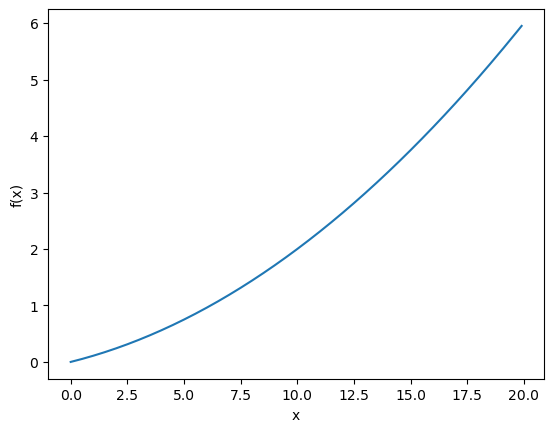

In [17]:
import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

0.1999999999990898


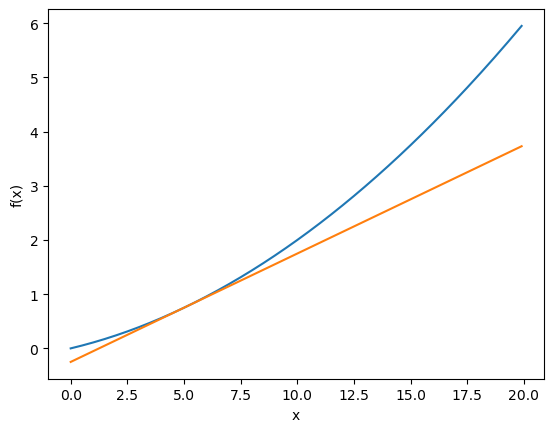

In [18]:
# coding: utf-8
import numpy as np
import matplotlib.pylab as plt


def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)


def function_1(x):
    return 0.01*x**2 + 0.1*x 


def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()

In [19]:
def function_2 (x):
    return x[0]**2 + x[1]**2

### 4.3.3 偏微分

$$f(x_0,x_1) = {x_0}^2 + {x_1}^2 \tag{4.6}$$

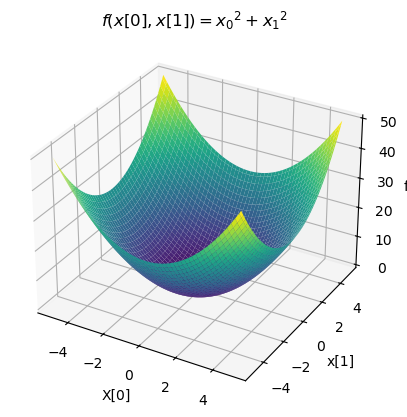

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def function_2(x):
    return x[0]**2 + x[1]**2

# x, y の範囲を設定
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = function_2([X, Y])

# 3D プロットの作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# ラベル設定
ax.set_xlabel('X[0]')
ax.set_ylabel('x[1]')
ax.set_zlabel('f(x)')
ax.set_title('$f(x[0], x[1]) = {x_0}^2 + {x_1}^2$')

plt.show()


それでは、式（4.6）の微分を求めたいと思います。ここで注意するポイントは、式（4.6）には変数が２つあるということです。

## 4.4 勾配

先の例では、$x_0$と$x_1$の偏微分の計算を変数ごとに計算しました。それでは、$x_0$と$x_1$の偏微分をまとめて計算したいと思います。たとえば、$x_0=3$、$x_1=4$のときの$(x_0,x_1)$の両方の偏微分をまとめて、$\left(\frac{\partial f}{\partial x_0},\frac{\partial f}{\partial x_0}\right)$として、計算することを考えましょう。なお、$\left(\frac{\partial f}{\partial x_0},\frac{\partial f}{\partial x_0}\right)$のように、すべての変数の偏微分をベクトルとしてまとめたものを**勾配**（gradient）と言います。勾配は、例えば、次のように実装することができます。

In [21]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad

numerical_gradient(f,x)関数は、引数の$f$は関数、$x$はNumPy配列であるとして、Numpy配列$x$の各要素に対して数値微分を求めます。それでは、この関数を使って、実際に勾配を計算してみましょう。

In [22]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [24]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [25]:
numerical_gradient(function_2, np.array([3.0, 0.0]))

array([6., 0.])

この勾配は何を意味しているのでしょうか？それを理解するために、$f(x_0,x_1)={x_0}^2+{x_1}^2$の勾配を図で表してみることにしましょう。ただし、ここでは勾配の結果にマイナスを付けたベクトルを描画します。

$f(x_0,x_1)={x_0}^2+{x_1}^2$の勾配は、図4-9のように向きを持ったベクトル（矢印）として図示されます。

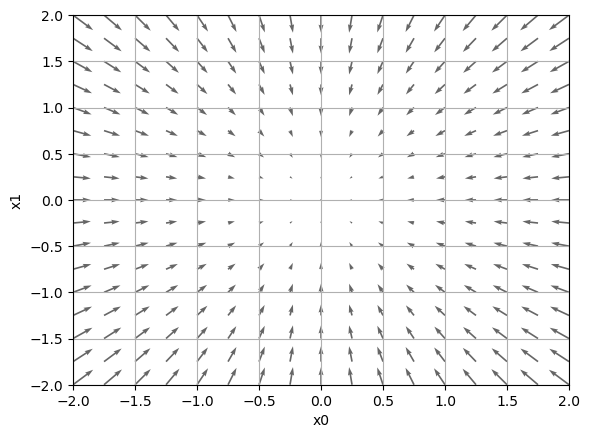

In [26]:
# coding: utf-8
# cf.http://d.hatena.ne.jp/white_wheels/20100327/p3
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D


def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 値を元に戻す
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y


if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()

    grad = numerical_gradient(function_2, np.array([X, Y]).T).T

    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.draw()
    plt.show()

<center>図4-9 $f(x_0,x_1)={x_0}^2+{x_1}^2$</center>

図4-9の例では、勾配は一番低い場所を指しましたが、実際は必ずしもそうなるとは限りません。しかし、勾配は、各地点において低くなる方向を指します。より正確に言うならば、勾配が示す方向は、各場所において**関数の値を最も減らす方向**です。

### 勾配法

機械学習の問題の多くは、学習の際に最適なパラメータを探索します。ニューラルネットワークも同様に最適なパラメータも同様に最適なパラメータ（重みとバイアス）を学習時に見つけなければなりません。ここで、最適なパラメータとは、損失関数が最小値を取るときのパラメータの値です。しかし、一般的に損失関数は複雑です。パラメータ空間は広大であり、どこに最小値をとる場所があるのか見当がつきません。そこで、勾配をうまく利用して関数の最小値（または、できるだけ小さな値）を探そう、というのが勾配法です。

ここでの注意点は、各地点において関数の値を最も減らす方向を示すのが勾配だということです。そのため、勾配が指す先が本当に関数の最小値なのかどうか、また、その先が本当に進むべき方向なのかどうか保証することはできません。実際、複雑な関数においては、勾配が指す方向は、最小値ではない場合がほとんどです。

関数の極小値や最小値または鞍点（saddle point）と呼ばれる場所では、勾配が０になります。極小値では、局所的な最小値、つまり、ある範囲に限定した場合にのみ最小値となる点です。また、鞍点とは、ある方向でみれば極大値で、別の方向で見れば極小値となる点です。勾配法は勾配が０の場所を探しますが、それが必ずしも最小値だとは限りません。（それは極小値や鞍点の可能性があります。）また、関数が複雑でいびつな形をしていると、（ほとんど）平らな土地に入り込み、「プラトー」と呼ばれる学習が進まない停滞期に陥ることがあります。

そこで勾配法の出番です。勾配法では、現在の場所から勾配方向に一定の距離だけ進みます。そして、異動した先でも同様に勾配を求め、また、その勾配方向へ進むというように、繰り返し勾配方向へ移動します。このように勾配方向へ進むことを繰り返すことで、関数の値を徐々に減らすのが**勾配法**（gradient method）です。勾配法は機械学習の最適化問題でよく使われる手法です。特に、ニューラルネットワークの学習では勾配法がよく使われます。

>勾配法は、目的が最小値を探すことか、それとも最大値を探すことかによって呼び名が変わります。正確には、最小値を探す場合を**勾配降下法**（gradient method）、最大値を探す場合を**勾配上昇法**（gradient ascent method）と言います。ただし、損失関数の符号を反転させれば、最小値を探す問題と最大値を探す問題は同じことになるので、「降下」か「上昇」かの違いは本質的には重要ではありません。一般的に、ニューラルネットワーク（ディ－プラーニング）の分野では、勾配法は「勾配降下法」として登場することが多くあります。

それでは、勾配法を数式で表してみます。勾配法を数式で表すと式（4.7）のように書くことができます。

$$
\begin{align}
x_0 = x_0 - \eta \frac{\partial f}{\partial x_0} \\
x_1 = x_1 - \eta \frac{\partial f}{\partial x_1}
\end{align}
\tag{4.7}
$$

式（4.7）の$\eta$は更新の量を表します。これは、ニューラルネットワークの学習においては、**学習率**（learning rate）と呼ばれます。１回の学習で、どれだけ学習すべきか、どれだけパラメータを更新するか、ということを決めるのが学習率です。

式（4.7）は１回の更新式を示しており、このステップを繰り返し行います。つまり、ステップごとに、式（4.7）のように変数の値を更新していき、そのステップを何度か繰り返すことによって徐々に関数の値を減らしていくのです。また、ここでは、変数が２つの場合を示していますが、変数の値が増えても、同じような式-それぞれの変数の偏微分の値-によって更新されることになります。

なお、が羽州率の値は、0.01や0.001など、前もって何らかの値に決める必要があります。この値は、オッパン的に、大きすぎても小さすぎても「良い場所」にたどり着くことができません。ニューラルネットワークの学習においては、学習率の値を変更しながら、正しく学習できているかどうか、確認作業を行うのが一般的です。

それでは、勾配降下法をPythonで実行しましょう。実装は簡単で、次のようになります。